In [1]:
ROOT_DIR ='/data/user/home/mhossai5/DPP-New2025'

In [6]:
import os
import re
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import logging
import tensorflow as tf
tf.get_logger().setLevel(logging.ERROR)
import warnings
warnings.filterwarnings('ignore')
import sys
import rdkit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import collections
import keras_hub as keras_nlp
import keras
import re
import wget
df_external_set = pd.read_parquet(os.path.join(ROOT_DIR,'data/dpp4-ext-26-03-25-feat.parquet'))

In [7]:
X_test = df_external_set['smiles']
y_test = df_external_set['target']

In [8]:
def load_vocab(vocab_file = ROOT_DIR+'/data/vocab.txt'):
    """Loads a vocabulary file into a dictionary."""
    if not os.path.exists(vocab_file):
        wget.download("https://github.com/deepchem/deepchem/raw/2.4.0/deepchem/feat/tests/data/vocab.txt" ,out = vocab_file)

    vocab = collections.OrderedDict()
    with open(vocab_file, "r", encoding="utf-8") as reader:
        tokens = reader.readlines()
    for index, token in enumerate(tokens):
        token = token.rstrip("\n")
        vocab[token] = index
    return vocab

vocab = load_vocab()
vocab_size = len(vocab)

In [9]:
# In Molecule generation there is difference tokenization method
# ref: https://github.com/devalab/molgpt/blob/72ff33ae747c0a4908b822732019a66e965a595a/generate/dataset.py#L41
# ref: https://github.com/Fraunhofer-SCAI/llamol/blob/main/tokenizer.py
from datasets import load_dataset
SMI_REGEX_PATTERN = r"""(\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\|\/|:|~|@|\?|>>?|\*|\$|\%[0-9]{2}|[0-9])"""
regex = re.compile(SMI_REGEX_PATTERN)
# ref: https://www.kaggle.com/code/hoyso48/2nd-place-solution-training?scriptVersionId=141882060&cellId=9
TABLE = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(list(vocab.keys()),tf.string),
        values=tf.constant(list(vocab.values()),tf.int32),
    ),
    default_value=tf.constant(-1),
    name="tokenize"
)
def encode_token(mol,target):
    def wrapper(smi):
        smi = smi.numpy().decode()
        return tf.constant(regex.findall(smi))
    
    mol = tf.py_function(wrapper,[mol],[tf.string])[0]
    
    mol = TABLE.lookup(mol)
    
    return tf.cast(mol,'int64'),target

def get_data(x,y, batch_size,pad_value = vocab['[PAD]'],shuffle=False):

    ds = tf.data.Dataset.from_tensor_slices((x,y))
    ds = ds.map(encode_token, tf.data.AUTOTUNE)
    
    if shuffle:
        ds = ds.shuffle(shuffle)

    if batch_size:
        ds = ds.padded_batch(batch_size, padding_values=tf.cast(pad_value,'int64'), padded_shapes=([max_len],[]))

    ds = ds.prefetch(tf.data.AUTOTUNE)

    return ds

I0000 00:00:1746601764.574967  101683 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 868 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:81:00.0, compute capability: 8.0


In [12]:
batch_size =8
max_len = 212
test_ds = get_data(X_test,y_test,batch_size=batch_size,)

In [13]:
from tensorflow.keras import ops
from tensorflow.keras import layers

In [14]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)
    
    
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

        
    def call(self, x):
        maxlen = ops.shape(x)[-1]
        positions = ops.arange(start=0, stop=maxlen, step=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions
    
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(max_len,))
embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embed_dim)
x = embedding_layer(inputs)
x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [15]:
model.load_weights(f'{ROOT_DIR}/weights/trans-v1-dpp4.keras')

In [16]:
y_pred_prob = model.predict(test_ds)
y_pred = y_pred_prob.argmax(-1)

I0000 00:00:1746601878.386548  102359 service.cc:148] XLA service 0x2aac6c002a80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746601878.386676  102359 service.cc:156]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
I0000 00:00:1746601878.530290  102359 cuda_dnn.cc:529] Loaded cuDNN version 90300


 57/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

I0000 00:00:1746601887.071928  102359 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


131/131 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step


In [17]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    matthews_corrcoef,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report,
    auc,
    ConfusionMatrixDisplay,
)
import matplotlib.pyplot as plt

In [18]:
print(f"accuracy_score: {accuracy_score(y_test,y_pred)}")
print(f"roc_auc_score: {roc_auc_score(y_test,y_pred)}")
print(f"matthews_corrcoef: {matthews_corrcoef(y_test,y_pred)}")
print(f"F1 Score: {f1_score(y_test,y_pred,average='macro')}")


accuracy_score: 0.6478468899521531
roc_auc_score: 0.638440366972477
matthews_corrcoef: 0.30955071192974853
F1 Score: 0.6251764173820831


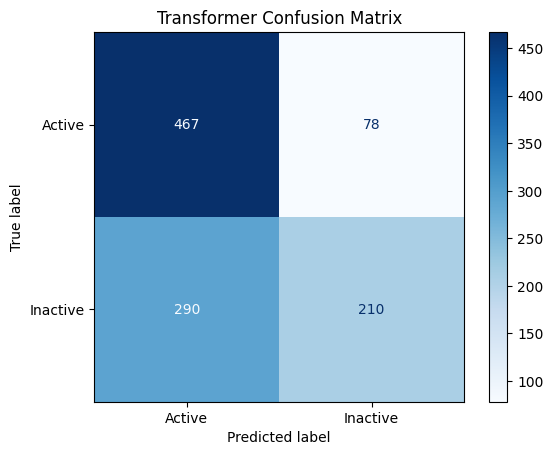

In [19]:
cm = confusion_matrix(y_test, y_pred)

# 6. Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels = ['Active', 'Inactive'])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Transformer Confusion Matrix")
plt.show()